In [1]:
import PIL
import PIL.ImageDraw
import random

In [2]:
import numpy as np
import os

from gymnasium import Env
from gymnasium.spaces import Discrete, Box, MultiDiscrete

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy


In [3]:
class RubkisCube:
    def __init__(self, moves_nr=10):
        self.cube = {"U":[['W', 'W', 'W'], ['W', 'W', 'W'], ['W', 'W', 'W']],
            "L":[['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O']],
            "F":[['G', 'G', 'G'], ['G', 'G', 'G'], ['G', 'G', 'G']],
            "R":[['R', 'R', 'R'], ['R', 'R', 'R'], ['R', 'R', 'R']],
            "B":[['B', 'B', 'B'], ['B', 'B', 'B'], ['B', 'B', 'B']],
            "D":[['Y', 'Y', 'Y'], ['Y', 'Y', 'Y'], ['Y', 'Y', 'Y']]
        }
        self.shuffle(moves_nr)
        
    def __str__(self):
        string = ""
        for face in self.cube.values():
            for row in face:
                for square in row:
                    string+=square
        return string
    '''
    def get_color(self, color: str):
        match color:
            case "R":
                return (255,0,0)
            case "G":
                return (0,255,0)
            case "B":
                return (0,0,255)
            case "W":
                return (255,255,255)
            case "Y":
                return (255,255,0)
            case "O":
                return (255,128,0)
    '''
    def get_color(self, color: str):
        if color == "R":
            return (255,0,0)
        elif color == "G":
            return (0,255,0)
        elif color == "B":
            return (0,0,255)
        elif color == "W":
            return (255,255,255)
        elif color == "Y":
            return (255,255,0)
        elif color == "O":
            return (255,128,0)
             
    def draw_cube(self):
        square_size = 50
        im = PIL.Image.new(mode="RGB", size=(square_size*12,square_size*9))
        draw = PIL.ImageDraw.Draw(im)

        positions = {
            "U": (3, 0),
            "L": (0, 3),
            "F": (3, 3),
            "R": (6, 3),
            "B": (9, 3),
            "D": (3, 6) 
        }

        for side, pos in positions.items():
            base_x, base_y = pos[0] * square_size, pos[1] * square_size
            
            for row in range(3):
                for col in range(3):
                    color = self.get_color(self.cube[side][row][col])

                    x1 = base_x + (col * square_size)
                    y1 = base_y + (row * square_size)
                    x2 = x1 + square_size
                    y2 = y1 + square_size
                    
                    draw.rectangle(
                        xy=(x1, y1, x2, y2),
                        fill=color,
                        outline=(0, 0, 0)
                    )
        #im.show()
        return im
    
    def rotate(self, move: str):
        face = move[0]
        direction = "CCW" if "'" in move else "CW"
        
        old_face = [row[:] for row in self.cube[face]]
        for i in range(3):
            for j in range(3):
                if direction == "CW":
                    self.cube[face][j][2-i] = old_face[i][j]
                elif direction == "CCW":
                    self.cube[face][2-j][i] = old_face[i][j]

        if face == "U":
            if direction == "CW":
                temp = self.cube["L"][0][:]
                self.cube["L"][0] = self.cube["F"][0][:]
                self.cube["F"][0] = self.cube["R"][0][:]
                self.cube["R"][0] = self.cube["B"][0][:]
                self.cube["B"][0] = temp
            elif direction == "CCW":
                temp = self.cube["L"][0][:]
                self.cube["L"][0] = self.cube["B"][0][:]
                self.cube["B"][0] = self.cube["R"][0][:]
                self.cube["R"][0] = self.cube["F"][0][:]
                self.cube["F"][0] = temp

        elif face == "D":
            if direction == "CW":
                temp = self.cube["L"][2][:]
                self.cube["L"][2] = self.cube["B"][2][:]
                self.cube["B"][2] = self.cube["R"][2][:]
                self.cube["R"][2] = self.cube["F"][2][:]
                self.cube["F"][2] = temp
            elif direction == "CCW":
                temp = self.cube["L"][2][:]
                self.cube["L"][2] = self.cube["F"][2][:]
                self.cube["F"][2] = self.cube["R"][2][:]
                self.cube["R"][2] = self.cube["B"][2][:]
                self.cube["B"][2] = temp

        elif face == "F":
            if direction == "CW":
                temp = self.cube["U"][2][:]
                self.cube["U"][2] = [self.cube["L"][2][2], self.cube["L"][1][2], self.cube["L"][0][2]]
                self.cube["L"][0][2], self.cube["L"][1][2], self.cube["L"][2][2] = self.cube["D"][0][:]
                self.cube["D"][0] = [self.cube["R"][2][0], self.cube["R"][1][0], self.cube["R"][0][0]]
                self.cube["R"][0][0], self.cube["R"][1][0], self.cube["R"][2][0] = temp
            elif direction == "CCW":
                temp = self.cube["U"][2][:]
                self.cube["U"][2] = [self.cube["R"][0][0], self.cube["R"][1][0], self.cube["R"][2][0]]
                self.cube["R"][0][0], self.cube["R"][1][0], self.cube["R"][2][0] = self.cube["D"][0][::-1]
                self.cube["D"][0] = [self.cube["L"][0][2], self.cube["L"][1][2], self.cube["L"][2][2]]
                self.cube["L"][0][2], self.cube["L"][1][2], self.cube["L"][2][2] = temp[::-1]

        elif face == "B":
            if direction == "CW":
                temp = self.cube["U"][0][:]
                self.cube["U"][0] = [self.cube["R"][0][2], self.cube["R"][1][2], self.cube["R"][2][2]]
                self.cube["R"][0][2], self.cube["R"][1][2], self.cube["R"][2][2] = self.cube["D"][2][::-1]
                self.cube["D"][2] = [self.cube["L"][0][0], self.cube["L"][1][0], self.cube["L"][2][0]]
                self.cube["L"][0][0], self.cube["L"][1][0], self.cube["L"][2][0] = temp[::-1]
            elif direction == "CCW":
                temp = self.cube["U"][0][:]
                self.cube["U"][0] = [self.cube["L"][2][0], self.cube["L"][1][0], self.cube["L"][0][0]]
                self.cube["L"][0][0], self.cube["L"][1][0], self.cube["L"][2][0] = self.cube["D"][2][:]
                self.cube["D"][2] = [self.cube["R"][2][2], self.cube["R"][1][2], self.cube["R"][0][2]]
                self.cube["R"][0][2], self.cube["R"][1][2], self.cube["R"][2][2] = temp

        elif face == "L":
            if direction == "CW":
                temp = [self.cube["U"][i][0] for i in range(3)]
                for i in range(3): self.cube["U"][i][0] = self.cube["B"][2-i][2]
                for i in range(3): self.cube["B"][i][2] = self.cube["D"][2-i][0]
                for i in range(3): self.cube["D"][i][0] = self.cube["F"][i][0]
                for i in range(3): self.cube["F"][i][0] = temp[i]
            elif direction == "CCW":
                temp = [self.cube["U"][i][0] for i in range(3)]
                for i in range(3): self.cube["U"][i][0] = self.cube["F"][i][0]
                for i in range(3): self.cube["F"][i][0] = self.cube["D"][i][0]
                for i in range(3): self.cube["D"][i][0] = self.cube["B"][2-i][2]
                for i in range(3): self.cube["B"][i][2] = temp[2-i]

        elif face == "R":
            if direction == "CW":
                temp = [self.cube["U"][i][2] for i in range(3)]
                for i in range(3): self.cube["U"][i][2] = self.cube["F"][i][2]
                for i in range(3): self.cube["F"][i][2] = self.cube["D"][i][2]
                for i in range(3): self.cube["D"][i][2] = self.cube["B"][2-i][0]
                for i in range(3): self.cube["B"][i][0] = temp[2-i]
            elif direction == "CCW":
                temp = [self.cube["U"][i][2] for i in range(3)]
                for i in range(3): self.cube["U"][i][2] = self.cube["B"][2-i][0]
                for i in range(3): self.cube["B"][i][0] = self.cube["D"][2-i][2]
                for i in range(3): self.cube["D"][i][2] = self.cube["F"][i][2]
                for i in range(3): self.cube["F"][i][2] = temp[i]

    def shuffle(self, moves=50):
        for _ in range(moves):
            move = random.choice(["F","R","U","B","L","D","F'","R'","U'","B'","L'","D'"])
            self.rotate(move)
        return self
    
    def check_score(self):
        return sum(sum(row.count(face[1][1]) for row in face) for face in self.cube.values())
    
    def check_done(self):
        return self.check_score() == 54
    
    def step(self, action):
        move = ["F","R","U","B","L","D","F'","R'","U'","B'","L'","D'"][action]
        self.rotate(move)
        #reward = 200 if self.check_score()==54 else (self.check_score()-54)/10
        #return reward
        return self.check_score()

# Building the Environment

In [4]:
class CubeEnv(Env):
    def __init__(self):
        self.action_space = Discrete(12)
        
        self.color_to_idx = {
            'W': 0,  # White
            'O': 1,  # Orange
            'G': 2,  # Green
            'R': 3,  # Red
            'B': 4,  # Blue
            'Y': 5   # Yellow
        }
        self.observation_space = Box(low=0, high=5, shape=(54,), dtype=np.int8)
        
        self.state = RubkisCube()
        self.moves_left = 50
        self.previous_score = self.state.check_score()
        
    def _state_to_observation(self):
        state_str = str(self.state)  # You might need to adjust this based on your RubkisCube class
        return np.array([self.color_to_idx[c] for c in state_str], dtype=np.int8)
    
    def step(self, action):
        current_score = self.state.step(action)
        self.moves_left -= 1

        improvement = current_score - self.previous_score
        move_penalty = -0.1  

        done = True if current_score==54 else False
        
        if done:
            reward = 200
        else:
            reward = improvement * 2.0  # Multiply improvement by 2 for stronger signal
            reward += move_penalty  # Add move penalty
            
        if self.moves_left == 0:
            done = True

        self.previous_score = current_score

        info = {
            'moves_remaining': self.moves_left,
            'current_score': current_score,
            'completion_percentage': (current_score / 54.0) * 100
            }
            
        return self._state_to_observation(), reward, done, False, info # false="truncated"
    
    def render(self):
        return self.state.draw_cube()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self.state = RubkisCube()
        self.moves_left = 50
        self.previous_score = self.state.check_score()

        info = {}

        return self._state_to_observation(), info

# Test Environment

In [5]:
'''
env_cub_test = CubeEnv()
episodes = 1
for episode in range(episodes):
    obs = env_cub_test.reset()
    done = False
    score = 0
    
    for _ in range(50):
        action = env_cub_test.action_space.sample()
        obs, reward, done,truncated, info = env_cub_test.step(action)
        score += reward
        print(score)
        #env_cub_test.render().show()
        if done:
            break
'''

'\nenv_cub_test = CubeEnv()\nepisodes = 1\nfor episode in range(episodes):\n    obs = env_cub_test.reset()\n    done = False\n    score = 0\n    \n    for _ in range(50):\n        action = env_cub_test.action_space.sample()\n        obs, reward, done,truncated, info = env_cub_test.step(action)\n        score += reward\n        print(score)\n        #env_cub_test.render().show()\n        if done:\n            break\n'

# Train Model

In [6]:
log_path = os.path.join('Training', 'Logs')
cube_model_path = os.path.join('Training', 'Saved Models', 'Cube_Model')
env_cub = CubeEnv()

In [7]:
model = PPO('MlpPolicy', env_cub, verbose=1, tensorboard_log=log_path, device='cpu')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [8]:
model.learn(total_timesteps=5_000_000)

Logging to Training\Logs\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    fps             | 1682     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -11.5       |
| time/                   |             |
|    fps                  | 1168        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010606024 |
|    clip_fraction        | 0.0886      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.48       |
|    explained_variance   | -0.00375    |

In [10]:
model.save(cube_model_path)

# Testing the model

In [13]:
#load
model = PPO.load(cube_model_path, env=env_cub)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\RoscaMitrut\.conda\envs\second_env\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [11]:
evaluate_policy(model, env_cub, n_eval_episodes=10)
#score mean / standard deviation

c:\Users\RoscaMitrut\.conda\envs\second_env\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(4.600000175088644, 10.499518911207472)

In [13]:
cub_env_nou = CubeEnv()

In [20]:
action, _states = model.predict(cub_env_nou._state_to_observation())
print(action)

2


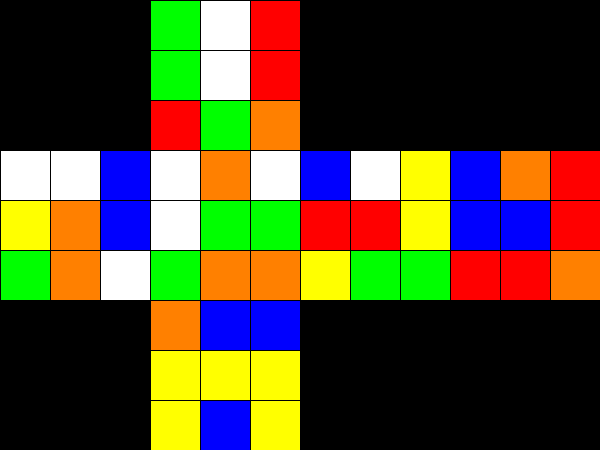

In [21]:
cub_env_nou.render()

In [19]:
cub_env_nou.step(action)

(array([2, 0, 3, 2, 0, 3, 3, 2, 1, 0, 0, 4, 5, 1, 4, 2, 1, 0, 0, 1, 0, 0,
        2, 2, 2, 1, 1, 4, 0, 5, 3, 3, 5, 5, 2, 2, 4, 1, 3, 4, 4, 3, 3, 3,
        1, 1, 4, 4, 5, 5, 5, 5, 4, 5], dtype=int8),
 7.9,
 False,
 False,
 {'moves_remaining': 48,
  'current_score': 17,
  'completion_percentage': 31.48148148148148})